# Desafio: Predição de valores da variável Withdrawal Amount - STEFANINI

### Autor: Matheus Jericó Palhares
### e-mail: matheusjerico1994@hotmail.com
### data: 18/07/2019

#### Definição do dataset:
- Account No. - representa o número da conta envolvida na transação.
- Date - data da transação.
- Transaction Details - narrações de transação em extratos bancários.
- Cheque No. - indica o número do cheque.
- Value Date - Data de conclusão da transação.
- Withdrawal Amount - Indica o montante retirado.
- Deposit Amount - Indica o valor depositado.
- Balance Amount - saldo atual da conta.

## DESAFIO: Predição de valores da variável Withdrawal Amount

#### Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import seaborn as sns
%matplotlib inline

#### 1. Importando dataset

In [2]:
path_csv = '/home/matheusjerico/Documentos/IA/Desafio_LSTM/bank.csv'

dataset = pd.read_table(path_csv, sep=',')

/home/matheusjerico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 2. Pré Processamento dos dados

In [3]:
dataset.head()

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',29/jun/17,TRF FROM Indiaforensic SERVICES,NaN,29/jun/17,NaN,"1.000.000,00","1.000.000,00",.
1,409000611074',5/jul/17,TRF FROM Indiaforensic SERVICES,NaN,5/jul/17,NaN,"1.000.000,00","2.000.000,00",.
2,409000611074',18/jul/17,FDRL/INTERNAL FUND TRANSFE,NaN,18/jul/17,NaN,"500.000,00","2.500.000,00",.
3,409000611074',1/ago/17,TRF FRM Indiaforensic SERVICES,NaN,1/ago/17,NaN,"3.000.000,00","5.500.000,00",.
4,409000611074',16/ago/17,FDRL/INTERNAL FUND TRANSFE,NaN,16/ago/17,NaN,"500.000,00","6.000.000,00",.


In [4]:
dataset.shape

(116201, 9)

#### 2.1. Renomeando as colunas

In [5]:
dataset = dataset.rename(columns={'Account No':'ACCOUNT_NO', 'DATE':'DATE', 'TRANSACTION DETAILS':'TRANSACTION_DETAILS',
                                'CHQ.NO.':'CHQ_NO','VALUE DATE':'VALUE_DATE',
                                ' WITHDRAWAL AMT ':'WITHDRAWAL_AMT',' DEPOSIT AMT ':'DEPOSIT_AMT',
                                'BALANCE AMT':'BALANCE_AMT', '.':'.'})

#### 2.2. Visualizando dados faltantes

In [6]:
dataset.isna().sum()

ACCOUNT_NO                  0
DATE                        0
TRANSACTION_DETAILS      2499
CHQ_NO                 115296
VALUE_DATE                  0
WITHDRAWAL_AMT          62652
DEPOSIT_AMT             53549
BALANCE_AMT                 0
.                           0
dtype: int64

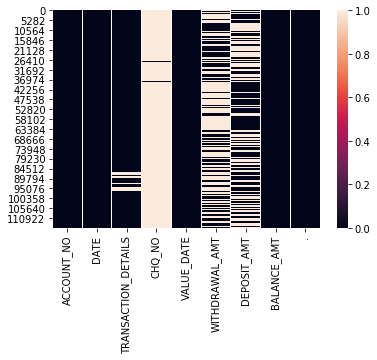

In [7]:
sns.heatmap(dataset.isna())

#### 2.3. Análise Exploratória

In [8]:
# Removendo coluna insignificante
df = dataset.drop(columns=['.'])

In [9]:
df.head(2)

,ACCOUNT_NO,DATE,TRANSACTION_DETAILS,CHQ_NO,VALUE_DATE,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
0,409000611074',29/jun/17,TRF FROM Indiaforensic SERVICES,NaN,29/jun/17,NaN,"1.000.000,00","1.000.000,00"
1,409000611074',5/jul/17,TRF FROM Indiaforensic SERVICES,NaN,5/jul/17,NaN,"1.000.000,00","2.000.000,00"


#### 2.3.1 Alterando valores numéricos em formato string para formato float

- Os valores das colunas WITHDRAWAL_AMT, DEPOSIT_AMT e BALANCE_AMT estão como string e com 'espaço' no início e no final.
- Dessa forma, vou remover os 'espaços' antes e depois do número em formato string.
- Vou retirar os 'pontos' dos dígitos e substituir a 'vírgula' por 'ponto'
- Transformar em float

In [10]:
df['WITHDRAWAL_AMT'] =df['WITHDRAWAL_AMT'].replace('\.','',regex=True).replace(',','.', regex=True).astype(float)
df['DEPOSIT_AMT'] =df['DEPOSIT_AMT'].replace('\.','',regex=True).replace(',','.', regex=True).astype(float)
df['BALANCE_AMT'] =df['BALANCE_AMT'].replace('\.','',regex=True).replace(',','.', regex=True).astype(float)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 8 columns):
ACCOUNT_NO             116201 non-null object
DATE                   116201 non-null object
TRANSACTION_DETAILS    113702 non-null object
CHQ_NO                 905 non-null float64
VALUE_DATE             116201 non-null object
WITHDRAWAL_AMT         53549 non-null float64
DEPOSIT_AMT            62652 non-null float64
BALANCE_AMT            116201 non-null float64
dtypes: float64(4), object(4)
memory usage: 7.1+ MB


Visualizando o cabeçalho com a modificação

In [12]:
df.head(3)

,ACCOUNT_NO,DATE,TRANSACTION_DETAILS,CHQ_NO,VALUE_DATE,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
0,409000611074',29/jun/17,TRF FROM Indiaforensic SERVICES,NaN,29/jun/17,NaN,1000000.0,1000000.0
1,409000611074',5/jul/17,TRF FROM Indiaforensic SERVICES,NaN,5/jul/17,NaN,1000000.0,2000000.0
2,409000611074',18/jul/17,FDRL/INTERNAL FUND TRANSFE,NaN,18/jul/17,NaN,500000.0,2500000.0


#### 2.3.2 Limpando colunas
- Alterando valores NaN da coluna TRANSACTION_DETAILS por 'blank' para futuro encoder;
- Remover valores NaN da coluna WITHDRAWAL_AMT (preditor);
- Remover colunas do CHQ_NO (muitos valores em branco) e DEPOSIT_AMT (não ocorre quando ocorre WITHDRAWAL_AMT .

In [13]:
df.TRANSACTION_DETAILS = df.TRANSACTION_DETAILS.fillna('blank')
df = df.dropna(subset=['WITHDRAWAL_AMT'])
df = df.drop(columns=['DEPOSIT_AMT', 'CHQ_NO'])

#### 2.3.3 Alterando os valores das datas para posterior categorização utilizando dia e mês
- A análise é para descobrir se existe alguma correlação entre o WITHDRAWAL com o dia e mês
- Sabe ser as transações tem um padrão mensal.

In [14]:
df.DATE = df.DATE.str[:-3]
df.VALUE_DATE = df.VALUE_DATE.str[:-3]

In [15]:
df.head(3)

,ACCOUNT_NO,DATE,TRANSACTION_DETAILS,VALUE_DATE,WITHDRAWAL_AMT,BALANCE_AMT
10,409000611074',16/ago,INDO GIBL Indiaforensic STL01071,16/ago,133900.0,8366100.0
11,409000611074',16/ago,INDO GIBL Indiaforensic STL02071,16/ago,18000.0,8348100.0
12,409000611074',16/ago,INDO GIBL Indiaforensic STL03071,16/ago,5000.0,8343100.0


#### 2.3.4 Manipulando a variável TRANSACTION_DETAILS
- Extrair apenas as 4 primeiras letras da TRANSACTION_DETAILS para decobrir futura correlação

In [16]:
df.TRANSACTION_DETAILS = df.TRANSACTION_DETAILS.str[:4]

Visualizar quantidades unicas de cada coluna com valores em formato string

In [17]:
print(len(df.ACCOUNT_NO.unique()))
print(len(df.DATE.unique()))
print(len(df.TRANSACTION_DETAILS.unique()))
print(len(df.VALUE_DATE.unique()))

10
364
455
363


#### 2.3.5 Categorizando as colunas que possuem valores em formato string.

- Verificar se existe correlação entre as colunas e a variável TARGET (WITHDRAWAL_AMT)

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
df.ACCOUNT_NO = le.fit_transform(df.ACCOUNT_NO)
df.DATE = le.fit_transform(df.DATE)
df.TRANSACTION_DETAILS = le.fit_transform(df.TRANSACTION_DETAILS)
df.VALUE_DATE = le.fit_transform(df.VALUE_DATE)

#### 2.3.6 Correlação entre variáveis.

- Verificar se existe correlação entre as colunas e a variável TARGET (WITHDRAWAL_AMT) com as demais

In [20]:
cor = df.corr()
cor

,ACCOUNT_NO,DATE,TRANSACTION_DETAILS,VALUE_DATE,WITHDRAWAL_AMT,BALANCE_AMT
ACCOUNT_NO,1.000000,-0.028876,-0.039895,-0.028963,-0.165416,0.886932
DATE,-0.028876,1.000000,-0.002394,0.999409,-0.003755,-0.023285
TRANSACTION_DETAILS,-0.039895,-0.002394,1.000000,-0.002393,0.158852,-0.107037
VALUE_DATE,-0.028963,0.999409,-0.002393,1.000000,-0.004276,-0.023325
WITHDRAWAL_AMT,-0.165416,-0.003755,0.158852,-0.004276,1.000000,-0.153841
BALANCE_AMT,0.886932,-0.023285,-0.107037,-0.023325,-0.153841,1.000000


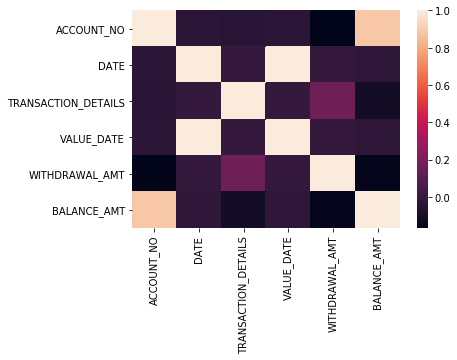

In [21]:
sns.heatmap(df.corr())

Verifica-se que a correlação da variável WITHDRAWAL_AMT com as demais variaveis é muito baixa

#### 2.3.6 Removendo colunas


In [22]:
# Removendo colunas
df = df.drop(columns=['DATE', 'VALUE_DATE', 'ACCOUNT_NO','BALANCE_AMT', 'TRANSACTION_DETAILS'])
# Resetando index
df = df.reset_index(drop=True)

In [23]:
df.head()

,WITHDRAWAL_AMT
0,133900.0
1,18000.0
2,5000.0
3,195800.0
4,81600.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53549 entries, 0 to 53548
Data columns (total 1 columns):
WITHDRAWAL_AMT    53549 non-null float64
dtypes: float64(1)
memory usage: 418.4 KB


#### 3. Tratar dos dados para implementar LSTM

#### 3.1. Definição memória (janela)
Definir a memória da LSTM, utilizando o parâmetro 'n_timesteps'. Utilizo o tamanho de 100 registros, quer dizer que para obter uma nova previsão, são utilizados 100 registros anteriores como memória. Esse é o tamanho da janela.


É necessário separar o dataset em treinamento e teste e separar cada pedaço (batch).

In [25]:
n_timesteps = 100

#### 3.2 Removendo valores outliers
- Valores considerados outliers podem atrapalhar o desempho do modelo

In [26]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [27]:
print("Shape antes de remover valores outlier: {}".format(df.shape))
df = remove_outlier(df, 'WITHDRAWAL_AMT')
print("Shape após de remover valores outlier: {}".format(df.shape))


Shape antes de remover valores outlier: (53549, 1)
Shape após de remover valores outlier: (46113, 1)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46113 entries, 0 to 53548
Data columns (total 1 columns):
WITHDRAWAL_AMT    46113 non-null float64
dtypes: float64(1)
memory usage: 720.5 KB


#### 3.3 Normalizando os dados
- A LSTM é sensível a grande variação dos dados de entrada. 
- Devido a esse problema, normalizamos os dados para valores entre 0 e 1 utilizando a função MinMaxScaler.

In [29]:
dados = np.array(df, dtype='float32')

In [30]:
scaler = MinMaxScaler(feature_range=(0,1))

In [31]:
dados_normalizados = scaler.fit_transform(dados)

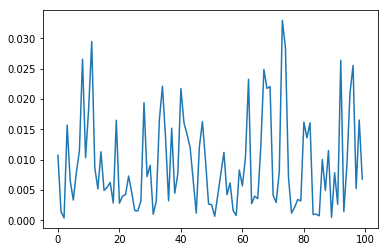

In [32]:
plt.plot(dados_normalizados[:100])

#### 3.4 Criação dos batchs e reshape dos dados para o padrão de entrada do tensorflow
O padrão de entrada do tensorflow é:
    - [tamanho_do_batch, tamanho_da_memoria (janela), qntd_atributos]
    - Em cada batch teremos 'n_timesteps' registros, no caso apresentado, 30 registros.
    
Os dados do X e do Y tem que estar deslocados em 1 unidade, por exemplo:
    - Se X vai de [0:50], Y tem que ir de [1:51] 

In [33]:
dados_normalizados.shape

(46113, 1)

In [34]:
X = dados_normalizados[0:((len(dados_normalizados) - len(dados_normalizados) % n_timesteps)-n_timesteps)]
print("X.shape: {}".format(X.shape))
# [tamanho do batch, tamanho da janela, quantidade de entradas]
X_batch = X.reshape(-1, n_timesteps, 1)
print("X_batch.shape: {}".format(X_batch.shape))

X.shape: (46000, 1)
X_batch.shape: (460, 100, 1)


In [35]:
Y = dados_normalizados[1:((len(dados_normalizados) - len(dados_normalizados) % n_timesteps)-(n_timesteps - 1))]
print('Y.shape: {}'.format(Y.shape))
# [tamanho do batch, tamanho da janela, quantidade de saida]
y_batch = Y.reshape(-1, n_timesteps, 1) 
print("y_batch.shape: {}".format(y_batch.shape))

Y.shape: (46000, 1)
y_batch.shape: (460, 100, 1)


#### 3.5 Criação e normalização dos dados de teste
- Da mesma forma que fiz com os dados de treino, entretanto, pego os dados finais

In [36]:
X_teste = dados[-(n_timesteps + 1):] # 101 dados finais
X_teste = X_teste[:n_timesteps] # não pega o ultimo dado
X_teste = scaler.transform(X_teste) # normaliza
X_teste = X_teste.reshape(-1, n_timesteps, 1) # reshape para input do tensorflow

y_teste = dados[-(n_timesteps):] # 100 dados finais
y_teste = y_teste.reshape(-1, n_timesteps, 1) # reshape para input do tensorflow
                                              # o y_teste não é normalizado

#### 3. Algoritmo LSTM

In [37]:
# reset grafo atual
tf.reset_default_graph()

#### 3.1 Parâmetros
- n_inputs: quantidade de atributos previsores. Utilizou-se apenas um parâmetro (WITHDRAWAL_AMT).
- n_nodes: quantidade de neurônios utilizados na camada ocultas. Definido após realizar alguns testes, alterando a quantidade até obter-se um bom resultado
- n_output: quantidade de atributos de saída. Para regressão, temos apenas uma saída

In [38]:
# nº de entradas
n_input = 1
# nodes da camada do LSTM
n_nodes = 100
# nº de saídas
n_output = 1

#### 3.2 Definição dos placeholders que vão receber os dados


In [39]:
# Criação dos placeholders
x = tf.placeholder(tf.float32,[None, n_timesteps, n_input])
y = tf.placeholder(tf.float32, [None, n_timesteps, n_output])

#### 3.3 Definição de uma célula LSTM
- Cada célula indica uma camada oculta

In [40]:
def criar_uma_celula():
    # Função para criar uma célula LSTM
    # Parâmetros: quantidade de nodes da camada (100), função de ativação (tanh)
    
    return tf.contrib.rnn.LSTMCell(num_units = n_nodes, activation = tf.nn.tanh)

#### 3.4 Função para criar N células (camadas) 
- Foram criadas 3 celúlas LSTM com Dropout.
- O uso de mais de uma célula pode melhorar os resultados.
- A camada de Dropout evita o overfitting do modelo.

In [41]:
def crias_varias_celulas(n_celulas):
    # Inicializo várias células
    celulas = tf.nn.rnn_cell.MultiRNNCell([criar_uma_celula() for i in range(0, n_celulas)])
    # Coloco droupout com valor de 0.1 
    return tf.contrib.rnn.DropoutWrapper(celulas, input_keep_prob= 0.9) # dropout

#### 3.5 Criando células ocultas e célula de saída
- Criação de 3 células e 1 camada de saída;
- Como tem 100 neurônios na camada oculta, preciso transformar em apenas um output (output_size = 1)

In [42]:
# Criando 3 células
celula = crias_varias_celulas(3)
# Criação da camada de saída,
# Apenas uma saída, pois queremos predizer apenas um parâmetro
celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size= n_output)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


#### 3.6 Criação da LSTM
- É necessário ter a saída da LSTM para calcular o erro, e posteriormente otimizar o erro das previsões.
- saida_lstm é a saída da RN, as predições


In [43]:
saida_lstm,_ = tf.nn.dynamic_rnn(celula, x, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 3.7 Erros e métricas:
- Função para cálculo do erro: mean_squared_error.
- Otimizador: AdamOptimizer

O otimizador mais adequado, depois de vários testes, foi o Adam com learning rate = 0.001 (valor default). A função de erro escolhida foi a MSE.



In [44]:
# Função para o cálculo do erro
# Parâmetros: o labels e as predições 
erro = tf.losses.mean_squared_error(labels=y, predictions=saida_lstm)
# Otimizador
otimizador = tf.train.AdamOptimizer()
# Treinamento, o objetivo é minimizar o erro
treinamento = otimizador.minimize(erro)

Instructions for updating:
Use tf.cast instead.


#### 3.8 Inicializando variáveis globais


In [45]:
init = tf.global_variables_initializer()

#### 3.9 Definição da quantidade de épocas

In [46]:
epocas = 1000
# Definição de quando mostrar as métricas
n_display = epocas/10

#### 4.0 Iniciando sessão do TensorFlow
- Inicializa variáveis;
- Loop de treinamento com duração das epocas definidas acima;
- Rodar treinamento da rede:
    - parâmetros: otimizador do erro, e função para cálculo do erro
- Realizar previsão.

In [47]:
# Inicio a sessão para treinamento e previsão
with tf.Session() as sess:
    sess.run(init)
    # Loop de épocas
    for epoca in range(epocas+1):
        # Faço o treinamento e passo os parâmetros que são utilizados nas funções 
        # 'tf.nn.dynamic_rnn' e 'tf.losses.mean_squared_error'
        _, loss = sess.run([treinamento, erro], feed_dict = {x: X_batch, y: y_batch})
        if epoca % n_display == 0:
            print('Epoca:', epoca, '\terro (MSE):', loss)
    
    # Realizando predições
    previsoes = sess.run(saida_lstm, feed_dict = {x: X_teste})

Epoca: 0 	erro (MSE): 0.06963952
Epoca: 100 	erro (MSE): 0.03580214
Epoca: 200 	erro (MSE): 0.034357373
Epoca: 300 	erro (MSE): 0.03370961
Epoca: 400 	erro (MSE): 0.033230133
Epoca: 500 	erro (MSE): 0.03251452
Epoca: 600 	erro (MSE): 0.031731438
Epoca: 700 	erro (MSE): 0.031318955
Epoca: 800 	erro (MSE): 0.030713845
Epoca: 900 	erro (MSE): 0.029616496
Epoca: 1000 	erro (MSE): 0.028971218


#### 5. Resultados

- Variáveis estão no formato tensor flow (3 dimensões), uso método ravel para diminuir suas dimensões.

In [48]:
y_teste_normal = np.ravel(y_teste)
print("y_teste.shape: {}".format(y_teste.shape))
print("y_teste_normal.shape: {}".format(y_teste_normal.shape))

y_teste.shape: (1, 100, 1)
y_teste_normal.shape: (100,)


In [49]:
previsoes_normal = np.ravel(previsoes)
print("previsoes.shape: {}".format(previsoes.shape))
print("previsoes_normal.shape: {}".format(previsoes_normal.shape))

previsoes.shape: (1, 100, 1)
previsoes_normal.shape: (100,)


#### 5.1 Desnormalização das previsões
Anteriormente eu normalizei os dados de treino, dessa forma, a predição foi feita com base nos dados normalizados.
Utilizo a função 'inverse_transform' para desnormalizar.

In [50]:
previsoes_normal = previsoes_normal.reshape(-1, 1)
print(previsoes_normal.shape)
previsoes_normal = scaler.inverse_transform(previsoes_normal) # Desnormalizando as previsões
previsoes_normal = np.squeeze(previsoes_normal) # Visualizar melhor

(100, 1)


#### 5.2 Métricas 
A métrica Mean Absolute Error informa a diferença do valor real com o valor previsto, que é bom para verificar a acurácia do modelo.



In [51]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste_normal, previsoes_normal)

In [52]:
def visualizar_resultados():
    for i in range(len(previsoes_normal)):
        print('Previsão:', previsoes_normal[i], '\tValor real:', y_teste_normal[i])
    print()
    print('Mean Absolute Error:', round(mae,4))

In [53]:
visualizar_resultados()

Previsão: 581840.75 	Valor real: 454854.66
Previsão: 1004148.56 	Valor real: 266.0
Previsão: 627624.9 	Valor real: 355.0
Previsão: 336428.47 	Valor real: 33365.0
Previsão: 221871.69 	Valor real: 652887.75
Previsão: 1244062.6 	Valor real: 19102.92
Previsão: 767805.5 	Valor real: 106083.61
Previsão: 665653.0 	Valor real: 9000.0
Previsão: 431947.66 	Valor real: 131275.03
Previsão: 574918.9 	Valor real: 392245.28
Previsão: 1165062.2 	Valor real: 547040.5
Previsão: 1623897.5 	Valor real: 925515.0
Previsão: 2254961.8 	Valor real: 62961.77
Previsão: 928803.2 	Valor real: 21390.0
Previsão: 327343.12 	Valor real: 103272.41
Previsão: -54530.41 	Valor real: 186082.95
Previsão: 181376.06 	Valor real: 42329.46
Previsão: 85985.41 	Valor real: 359575.28
Previsão: 38960.582 	Valor real: 365031.56
Previsão: 772772.3 	Valor real: 22213.0
Previsão: 473764.22 	Valor real: 22563.0
Previsão: 355036.12 	Valor real: 1373.0
Previsão: 292854.66 	Valor real: 697.0
Previsão: 294523.1 	Valor real: 176.0
Previsão: 

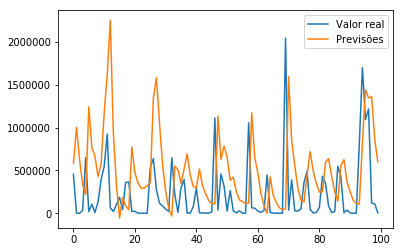

In [54]:
plt.plot(y_teste_normal, label = 'Valor real')
plt.plot(previsoes_normal, label = 'Previsões')
plt.legend()